In [14]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from model import VAE
import h5py
from ipywidgets import interact, FloatSlider


In [2]:
def sample_z(z_mean, z_log_sigma_sq):
        eps_shape = z_mean.shape
        eps = np.random.normal(0, 1, eps_shape)
        z = np.sqrt(np.exp(z_log_sigma_sq)) * eps + z_mean
        return z


In [3]:
sess = tf.Session()

model = VAE(
    input_width=128,
    input_height=128,
    input_channels=3,
    gamma=1000,
    capacity_limit=300,
    capacity_change_duration=100000,
    learning_rate=5e-4,
)

sess.run(tf.global_variables_initializer())

checkpoint_path = 'checkpoints/'
saver = tf.train.Saver()
checkpoint = tf.train.get_checkpoint_state(checkpoint_path)
if checkpoint and checkpoint.model_checkpoint_path:
    saver.restore(sess, checkpoint.model_checkpoint_path)
    print("loaded checkpoint: {0}".format(checkpoint.model_checkpoint_path))
else:
    print("Could not find old checkpoint")


    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-852000
loaded checkpoint: checkpoints/checkpoint-852000


In [4]:
def build_interactive_z(z_vec, only_display_these_idx = None): # only_display_these_idx: Only display certain idx
    z_dict = {}
    _max = np.max(z_vec)
    _min = np.min(z_vec)
    for idx, _z in enumerate(z_vec[0]):
        if (only_display_these_idx is not None) and idx not in only_display_these_idx: # Optional
            continue
        z_dict['%d' % idx] = FloatSlider(min=_min, max=_max, value=_z, step=0.01, description='z%d' % idx)
        
    return z_dict

## Visualize VAE

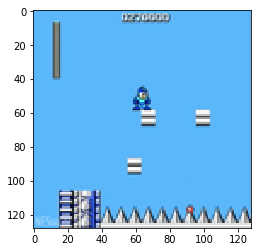

In [5]:
dataset_zip = h5py.File('data/megaman.hdf5', 'r')
imgs       = dataset_zip['megaman']
idx = np.random.randint(imgs.shape[0])
#img = np.random.choice(imgs)
img = imgs[idx]

plt.imshow(img)
plt.show()

In [15]:
def z_interact(*args, **kwargs):  # Event handler for interactive sliders
    for key, value in kwargs.items():
        idx = int(key)
        z[0, idx] = value
        
    # Interactively draw output
    out = model.generate(sess, z)
    out_img = out.reshape([128, 128, 3])
    plt.imshow(out_img)
    plt.show()
    
img_flat = img.reshape([1, 49152])
z_mean, z_log_sigma_sq = model.transform(sess, img_flat)
z = sample_z(z_mean, z_log_sigma_sq)
zix = np.argsort(np.exp(z_log_sigma_sq))[0,:10] #np.random.randint(0, z.shape[1], 10) #
print(zix)
z_dict = build_interactive_z(z, only_display_these_idx=zix)
interact(z_interact, **z_dict)



[182 175 108 176 107 223  47  32 140  50]


interactive(children=(FloatSlider(value=1.1365597255965711, description='z32', max=2.49607483835604, min=-2.59…

<function __main__.z_interact(*args, **kwargs)>

[182 175 108 176 107 223  47  32 140  50]
-0.06998845937070504
z -1.05368220796683
-0.06998845937070504


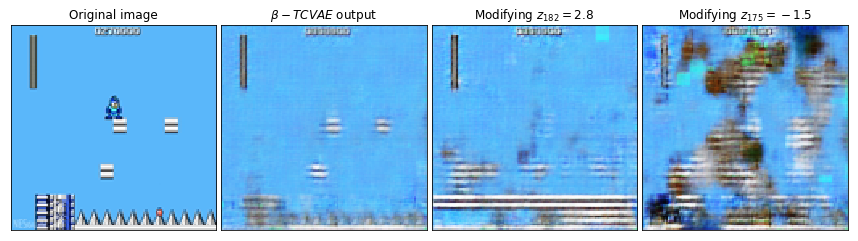

In [104]:
img_flat = img.reshape([1, 49152])
z_mean, z_log_sigma_sq = model.transform(sess, img_flat)
z = sample_z(z_mean, z_log_sigma_sq)
zix = np.argsort(np.exp(z_log_sigma_sq))[0,:10] #np.random.randint(0, z.shape[1], 10) #
print(zix)

def show_img(out_img, grid, title):
    ax = fig.add_subplot(grid)
    ax.imshow(out_img, cmap='gray', vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)

gs = gridspec.GridSpec(1, 4)
gs.update(wspace=0.025, hspace=0.02)
fig = plt.figure(figsize = (15,5))


show_img(img, gs[0,0], r'Original image')

# == VAE Out
out = model.generate(sess, z)
out_img = out.reshape([128, 128, 3])
show_img(out_img, gs[0,1], r'$ \beta-TCVAE$ output')


# == z = 2.8
z1 = z.copy()
z1[0,50] += -3.5
print(z[0,182])
out2 = model.generate(sess, z1)
out_img = out2.reshape([128, 128, 3])
show_img(out_img, gs[0,2],r"Modifying $z_{182} = 2.8$" )

# == z = 2.8
print('z', z[0,223])
z2 = z.copy()
change = 1.6
z2[0,175] += change
print(z[0,182])
out2 = model.generate(sess, z2)
out_img = out2.reshape([128, 128, 3])
show_img(out_img, gs[0,3],r"Modifying $z_{175}= -1.5$" )


fig.tight_layout()
plt.tight_layout()
plt.savefig('vae_comparison.png')
plt.show()



